# Прогноз оттока клиентов в сети «Культурист-датасаентист»

Цель фитнес-центра «Культурист-датасаентист» — сохранить как можно больше клиентов. Для этого важно понимать, когда каждый из них может уйти, и вовремя применить меры по удержанию.

**Нам поставлены следующие задачи:**
- Обучить модель машинного обучения прогнозировать вероятность ухода клиента в течение следующего месяца.
- Определить типичные портреты клиентов, разделив их на 5 групп с наиболее характерными чертами.
- Выявить основные факторы, которые сильнее всего влияют на отток клиентов.
- На основе полученных данных сформулировать выводы и разработать рекомендации по улучшению работы с клиентами в каждой группе, чтобы снизить уровень оттока.

**План работы:**
- Загрузить данные из полученного файла
- Провести исследовательский анализ данных
- Построить модель прогнозирования оттока клиентов
- Провести кластеризацию клиентов
- Сформулировать выводы и написать рекомендации по работе для удержания клиентов

**Описание данных**
- `gender` — пол
- `near_location` — проживание или работа в районе, где находится фитнес-центр
- `partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `phone` — наличие контактного телефона
- `contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год)
- `group_visits` — факт посещения групповых занятий
- `age` — возраст
- `avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон
- `month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)
- `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `churn` — факт оттока в текущем месяце

## Чтение данных

In [1]:
#импортируем библиотеки для работы
import pandas as pd
import math as mth
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
!pip install phik 
import phik
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score)

#устанавливаем единый стиль для графиков
sns.set_palette(list(reversed(sns.color_palette('rocket'))))
palette = list(reversed(sns.color_palette('rocket')))
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
#выводим все стоблцы в таблицах
pd.set_option('display.max_columns', None)

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
#считываем данные из файла
df = pd.read_csv('/datasets/gym_churn.csv')
#выведем общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Весь датасет занимает 4000 строк с 14 столбцами. Все значения числовые с типами int и float. Пропусков нет.

In [3]:
#посчитаем дубликаты
df.duplicated().sum()

0

Дублирующих друг друга строк в датасете также нет, мы имеем дело с данными о 4000 уникальных клиентов.

In [4]:
#выведем первые 5 строк
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Почти половина столбцов содержит данные с буллевыми значениями, где 1 равно `True`, а 0 — `False`. В случае с полом клиентов принадлежность к числовому лейблу не имеет значения в рамках обучения модели.

Столбец с количеством месяцев до окончания текущего абонемента относится к типу float, хотя месяца не в дробных значениях, данные можно перевести в int. Также необходимо привести наименования столбцов к нижнему регистру.

## Исследовательский анализ данных

### Предобработка данных

In [5]:
#приводим наименования столбцов к нижнему регистру
df.columns = df.columns.str.lower()
#переводим month_to_end_contract к цельночисловому значению
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
#проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Столцы успешно переведены в нижний регистр, а количество месяцев до конца абонемента — в цельночисловой тип. Приступим к изучению данных.

### Изучение статистики датасета

In [6]:
#посмотрим на общую статистику
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- Признаки по полу распределены почти пополам: 51% к 49% мужчин и женщин.
- Большая часть клиентов живёт или работает возле фитнес-центра: 84,5%.
- Почти половина из них является работниками компаний-партнёров центра.
- Около 40% клиентов посещают групповые занятия.
- Факт оттока подтверждён у 26,5% клиентов.

Самые большие выбросы в суммарной выручке от доп. услуг — `avg_additional_charges_total`, также наблюдаем выбросы в `lifetime` и средней частоте посещений: `avg_class_frequency_total` и `avg_class_frequency_current_month`.
Изучим эти выбросы поближе.

### Изучение выбросов

Так как выбросы мы планируем изучать по 4 столбцам, а для наглядности в разрезе наличия оттока, то это будут однотипные графики. 

Напишем для типичных графиков размаха функцию.

In [7]:
#функция для построения двойных диаграмм размаха
def df_boxplot(df_column, df_title, df_xlabel, df_xticks):
    plt.figure(figsize=(14, 5))
    sns.boxplot(x=df_column, y='churn', data=df, orient='h')
    plt.title(df_title, fontsize=14)
    plt.xlabel(df_xlabel, fontsize=12)
    plt.ylabel('')
    plt.yticks([0, 1], ['Остались', 'Ушли'], fontsize=12)
    plt.xticks(df_xticks)
    plt.show()

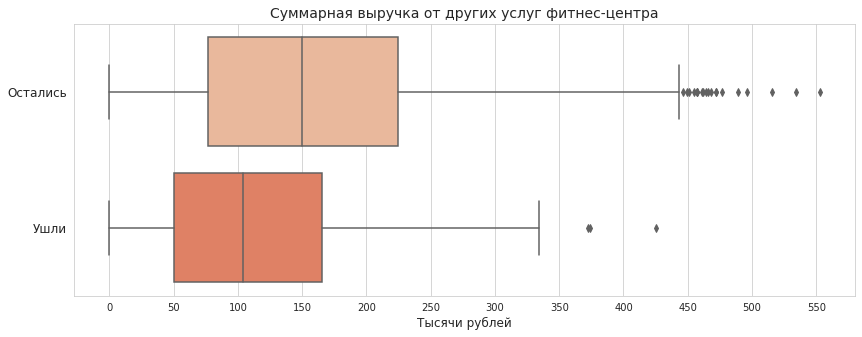

In [8]:
#строим диаграммы размаха для avg_additional_charges_total
df_boxplot('avg_additional_charges_total', 
           'Суммарная выручка от других услуг фитнес-центра', 
           'Тысячи рублей', 
           range(0, 600, 50))

Судя по диаграммам размаха, половина остающихся клиентов тратит на дополнительные услуги до 150 тысяч рублей, в то время как у ушедших медиана едва превышает 100. 

В обеих группах нижняя граница находится на нуле, что говорит о том, что клиенты, которые приходят в фитнес-центр только ради тренинга, — тоже не редкость. 

Среди ушедших есть те, кто потратил больше 330 тысяч, но значения выше этих — уже аномальны, в то время как у оставшихся клиентов суммы свыше 400 тысяч аномалиями ещё не являются. Впрочем, выбросы с куда большими денежными вливаниями у остающихся клиентов встречаются чаще. 

Рассмотрим подробнее, сколько месяцев посещают фитнес-центр клиенты из нашего датасета.

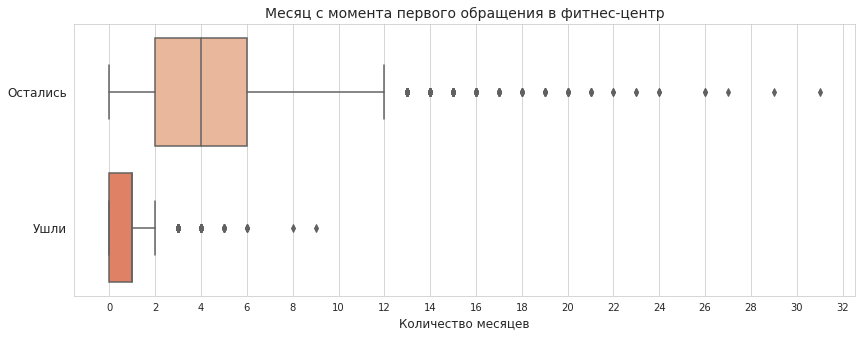

In [9]:
#строим диаграммы размаха для lifetime
df_boxplot('lifetime', 
           'Месяц с момента первого обращения в фитнес-центр', 
           'Количество месяцев', 
           range(0, 33, 2))

Редкий ушедший клиент посещает фитнес-центр дольше 2 месяцев, с этого значения выбросы и начинаются.

Медиана оставшихся клиентов пользуется услугами фитнес-центра до 4 месяцев, а выбросы начинаются через год после начала посещений.

Посмотрим на график корреляций в разрезе этих двух значений.

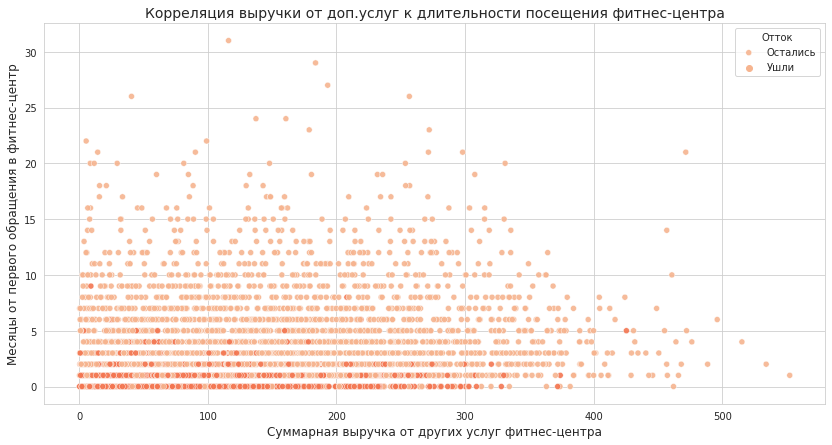

In [10]:
#строим график корреляции 
plt.figure(figsize=(14, 7))
sns.scatterplot(x='avg_additional_charges_total', y='lifetime', hue='churn', data=df, alpha=0.9)
plt.title('Корреляция выручки от доп.услуг к длительности посещения фитнес-центра', fontsize=14)
plt.xlabel('Суммарная выручка от других услуг фитнес-центра', fontsize=12)
plt.ylabel('Месяцы от первого обращения в фитнес-центр', fontsize=12)
plt.legend(title='Отток', labels=['Остались', 'Ушли'])
plt.grid(True)
plt.show()

Связи между длительностью посещений и суммами на доп. услуги нет в обеих группах. 

Самые крупные суммы, попадающие в выбросы, чаще всего тратили клиенты, которые посещают фитнес-центр до 10 месяцев. Впрочем, клиентов, которые в целом ходят в фитнес-центр до 10 месяцев, в нашей выборке преобладающее количество.

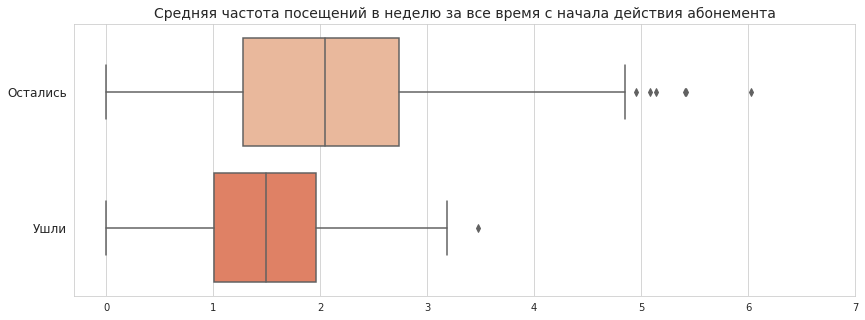

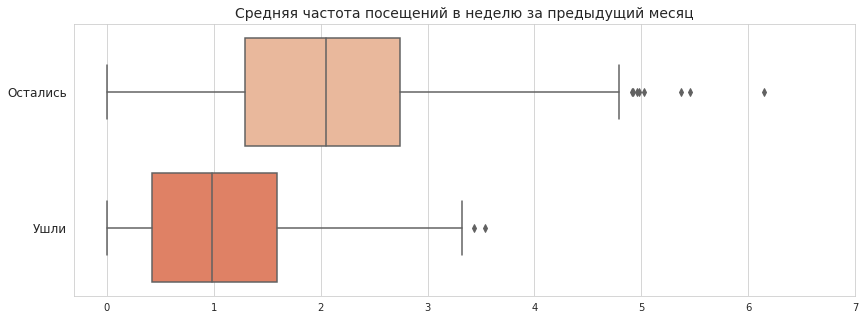

In [11]:
#строим диаграммы размаха для avg_class_frequency_total
df_boxplot('avg_class_frequency_total', 
           'Средняя частота посещений в неделю за все время с начала действия абонемента', '', 
           range(0, 8, 1))
#строим диаграммы размаха для avg_class_frequency_current_month
df_boxplot('avg_class_frequency_current_month', 
           'Средняя частота посещений в неделю за предыдущий месяц', '', 
           range(0, 8, 1))

Мы выровняли оси на обоих графиках, что позволяет нам сравнить два похожих показателя средней частоты посещений фитнес-зала в неделю от начала абонемента и за предыдущий месяц.
- Для клиентов, которые не ушли в отток, количество посещений почти не меняется и за предыдущий месяц, и за время действия абонемента, что говорит о большей мотивации. Половина из этих клиентов посещает фитнес-центр в среднем более двух раз в неделю. Редкие выбросы начинаются от 5 дней, возможно, речь об увлечённых спортсменах, которые ходят в зал как на работу.
- Среди клиентов, ушедших в отток, мы видим, что средняя частота посещений в неделю за всё время с начала действия абонемента у половины около полутора дней. Единицы посещают фитнес-центр больше 3 дней в неделю, а после этого бросают занятия. А за предыдущий месяц картина ещё более плачевная: половина клиентов, покинувших фитнес-центр, ходит на занятия меньше 1 раза в неделю, и, хотя аномально частые значения начинаются после 3,25 дней, в целом ситуация выглядит хуже.

Все рассмотренные выбросы мы сохраним для дальнейшего обучения и вернёмся к ним лишь при необходимости. Впрочем, они выглядят достаточно реалистичными, так как находятся достаточно близко к основному массиву наблюдений.

Посмотрим на средние значения признаков в зависимости от целевой переменной.

### Изучение средних значений

In [12]:
#рассчитаем средние значения по целевому признаку churn
df_gr_churn = df.groupby('churn').agg('mean').T
df_gr_churn.columns = ['Остались', 'Ушли']
df_gr_churn

,Остались,Ушли
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


По получившейся сводной таблице мы можем сказать следующее: 

- Пол не оказывает значительного влияния на отток клиентов, так как доля мужчин и женщин одинаковы как среди тех, кто ушёл, так и среди оставшихся. 
- Клиенты, которым проходится преодолевать большее расстояние до фитнес-центра, уходят чаще (в 23,4% случаев против 12,3%). Значит, близость к фитнес-центру положительно влияет на удержание клиентов. 
- Сотрудники компаний-партнёров чаще продолжают посещать фитнес-центр (остаётся 53,4%, а уходят 35,5%). Это говорит о том, что корпоративные программы могут способствовать удержанию клиентов. 
- Те, кто пришел по акции, с большей вероятностью остаются клиентами (35,4% против 18,4%). 
- Наличие контактного телефона не оказывает влияния на отток. 
- Остающиеся клиенты имеют более длительные текущие абонементы (в среднем 5,75 месяцев) по сравнению с ушедшими (1,73 месяца). 
- Участие в групповых занятиях также способствует удержанию клиентов (46,4% против 26,9%). 
- В среднем оставшиеся клиенты старше по сравнению с ушедшими в отток. 
- Клиенты, которые остались, тратят больше на дополнительные услуги фитнес-центра. Но помним, что в этой категории были выбросы, которые следует изучить отдельно. 
- Те, кто ушёл, имеют меньше месяцев до окончания текущего абонемента (1,66 против 5,28). Это логично, так как клиенты с длительными абонементами менее склонны к оттоку. 
- Чем дольше клиент посещает фитнес-центр, тем меньше вероятность его ухода (4,71 месяца против 0,99). 
- При более частых посещениях в неделю как за весь период абонемента, так и за последний месяц вероятность, что клиент не уйдёт, выше. 

Изучим выбросы в четырёх столбцах поближе.

### Распределение признаков

Среди признаков, которые у нас есть, можно выделить категориальные и количественные.

**К категориальным относятся признаки:**
- `gender`
- `near_location`
- `partner`
- `promo_friends`
- `phone`
- `group_visits`

**К количественным:**
- `contract_period`
- `age`
- `avg_additional_charges_total`
- `month_to_end_contract`
- `lifetime`
- `avg_class_frequency_total`
- `avg_class_frequency_current_month`

Сгруппируем их в отдельные переменные.

In [13]:
#список категориальных признаков
categorical_features = ['gender', 'phone', 'near_location', 'group_visits', 'partner', 'promo_friends']
#список количественных признаков
quantitative_features = ['contract_period', 'month_to_end_contract', 'age', 'lifetime', 
                         'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']

Категориальные будет удобнее сравнить в разрезе целевой переменной на обычном столбчатом графике, а для количественных мы построим столбчатые гистограммы с распределением. Так как в дальнейшем мы будем рассматривать графики по группам кластеров, то создадим функции с их учётом.

In [14]:
#функция для построения графиков по категориальным признакам 
def df_countplot(df_column, df_title, ax=None, cluster_number=None):
    if cluster_number is not None:
        df_filtered = df[df['cluster_km'] == cluster_number]
    else:
        df_filtered = df
    sns.countplot(y=df_column, hue='churn', data=df_filtered, ax=ax)
    ax.set_title(df_title, fontsize=14)
    ax.set_xlabel('Количество клиентов', fontsize=12)
    ax.set_ylabel('')
    ax.legend(labels=['Остались', 'Ушли'])

In [15]:
#функция для построения гистограммы распределения
def df_histplot(df_column, df_title, df_xlabel, churn_value, ax=None, cluster_number=None):
    if cluster_number is not None:
        df_filtered = df[(df['churn'] == churn_value) & (df['cluster_km'] == cluster_number)]
    else:
        df_filtered = df[df['churn'] == churn_value]
    sns.histplot(df_filtered[df_column], color=palette[churn_value], kde=True, stat='count', alpha=0.5, ax=ax)
    ax.set_title(df_title, fontsize=14)
    ax.set_xlabel(df_xlabel, fontsize=12)
    ax.set_ylabel('Количество наблюдений', fontsize=12)
    ax.legend(['Ушли', 'Остались'])

Так как на графиках не будет уникальных подписей по группам 0 и 1, отметим сразу их значения:
- По столбцу `gender` мы не знаем принадлежности пола к числовому лейблу, но это и не имеет значения.
- По столбцу `phone`, где 1 — номер телефона указан.
- По столбцу `near_location`, где 1 — работают или живут поблизости.
- По столбцу `group_visits`, где 1 — клиент ходит на групповые занятия.
- По столбцу `partner`, где 1 — клиентом является сотрудник компании-партнёра.
- По столбцу `promo_friends`, где 1 — клиент пришёл по акции.

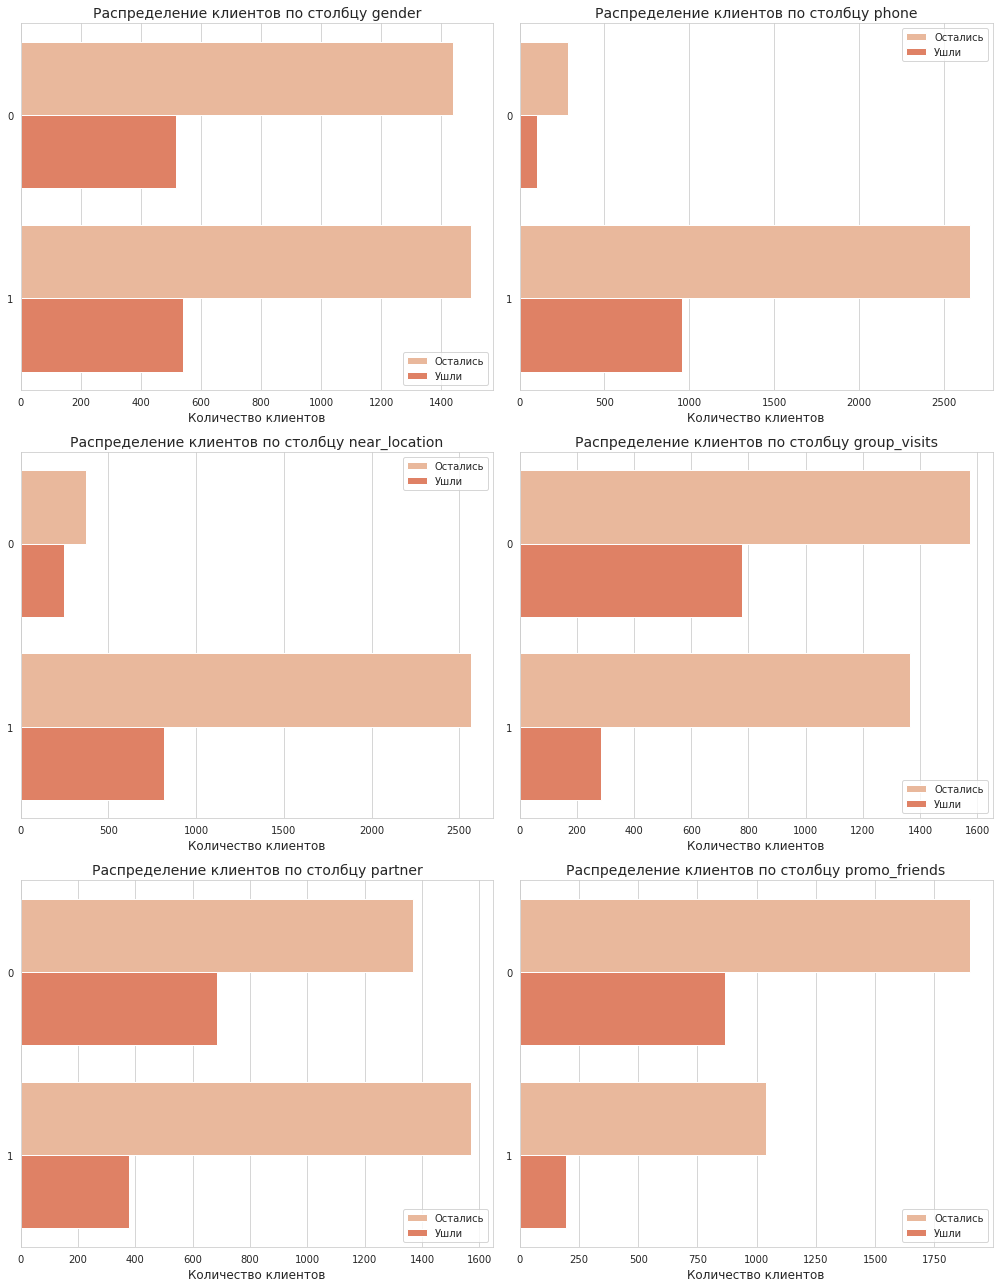

In [16]:
#создаем сетку для графиков
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
#перебираем категориальные признаки и вызываем функцию для построения графиков
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    df_countplot(feature, f'Распределение клиентов по столбцу {feature}', ax=axes[row, col])
plt.tight_layout()
plt.show()

Данные графики наглядно отображают инсайты, которые мы обнаружили при изучении статистики и сводной таблицы. 
- В фитнес-центр ходит достаточно мало клиентов, не живущих или работающих поблизости. При этом доля оттока у них гораздо выше. 
- Большинство клиентов не посещает групповые занятия, а отток — более половины. 
- Корпоративные программы положительно влияют на удержание клиентов. 
- В акции «Приведи друга» участвует немного клиентов, но показатели по удержанию среди них гораздо выше. 

Рассмотрим распределения признаков у количественных признаков на гистограммах.

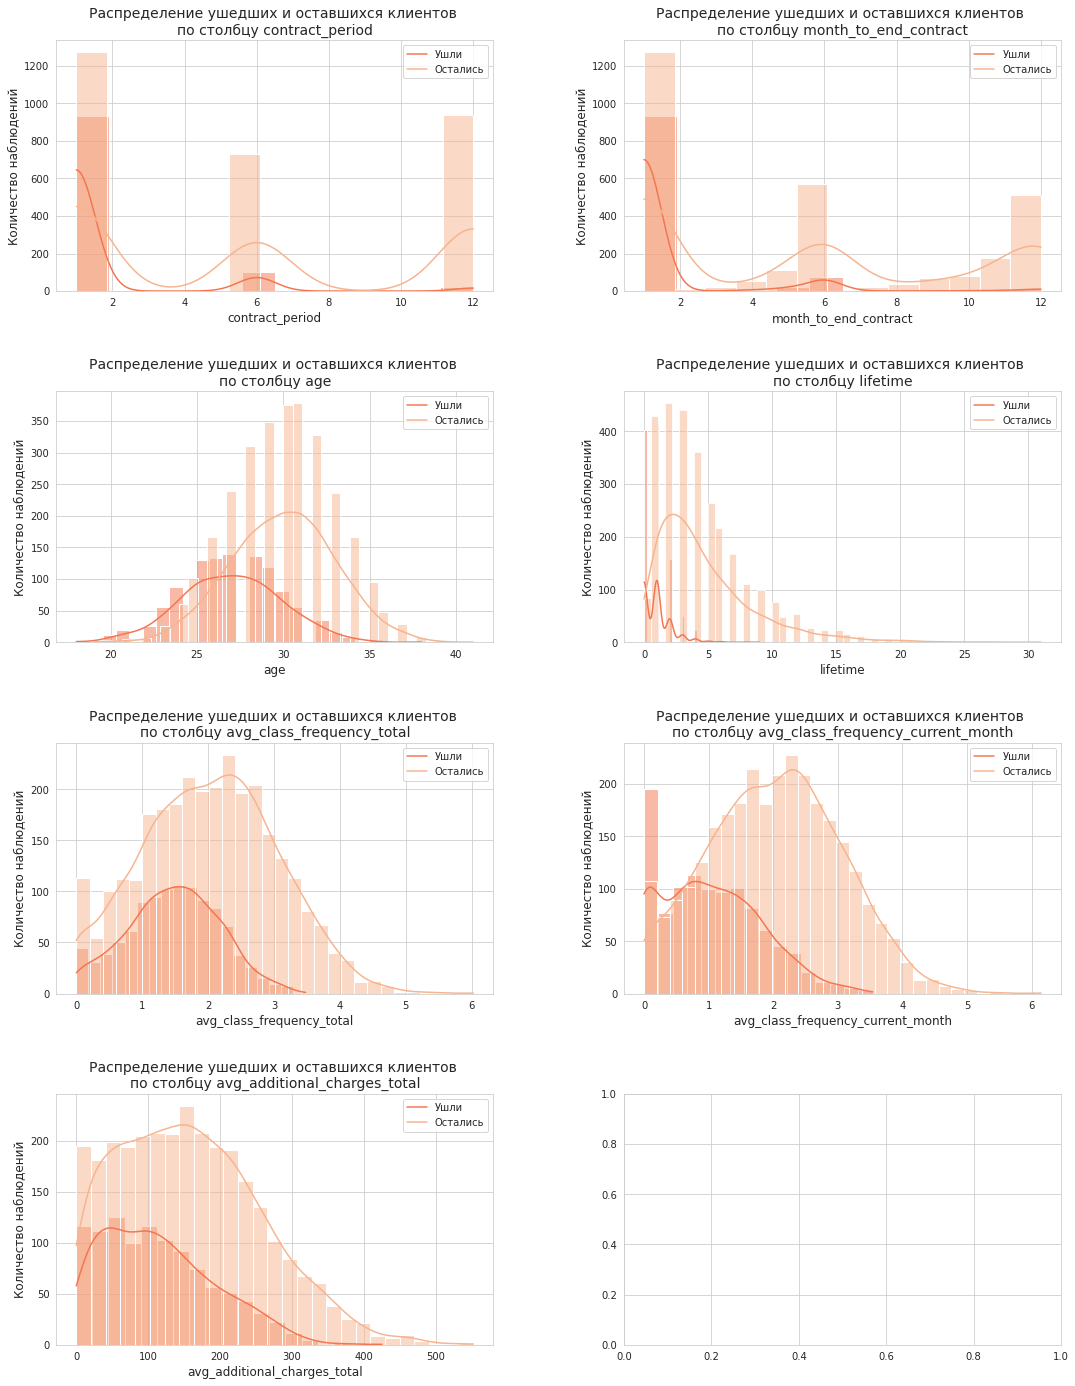

In [17]:
#создаем сетку для графиков
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
#перебираем количественные признаки и вызываем функцию для построения гистограммы распределения
for i, feature in enumerate(quantitative_features):
    row = i // 2
    col = i % 2
    # Указываем номер кластера вручную при вызове функции
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', feature, 1, ax=axes[row, col])
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', feature, 0, ax=axes[row, col])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

Эти графики также наглядно иллюстрируют изученную ранее статистику и сводную таблицу. 
- Наибольшее количество ушедших в отток клиентов используют короткие абонементы, небольшая доля из них приобретает полугодовые. У оставшихся клиентов большое количество годовых абонементов, но преобладают месячные. 
- Немалое количество ушедших клиентов не остановило даже наличие полугодового абонемента, и они перестали посещать фитнес-центр почти сразу. У клиентов, которых удалось удержать, остаток распределён достаточно равномерно. 
- Клиенты, которые прекратили пользоваться услугами центра, в основном имеют возраст около 27 лет. Это можно увидеть на графике с нормальным распределением с пиком в этой области. В то же время те, кто продолжает пользоваться нашими услугами, имеют более высокий возраст, что указывает на то, что после 30 лет без спорта хорошо жить становится сложнее. 
- По длительности посещения фитнес-центра у удержанных клиентов мы наблюдаем нормальное распределение со смещением влево, наибольшая доля оставшихся посещает фитнес-центр около 3–4 месяцев. А вот среди ушедших график распределения напоминает параболу со снижением, которая уходит в ноль после 5 месяцев посещений. 
- У оставшихся клиентов график распределения указывает на 2 пика в районе 1,7 и 2,3 средних посещений в неделю на протяжении использования всего абонемента. А ушедшие в среднем ходят около 1,5 раз в неделю. 
- За последний месяц ушедшие в отток часто вообще не посещали фитнес-центр, а среди посещающих график распределения указывает на пик ниже 1 посещения в неделю. Оставшиеся клиенты посещают центр более стабильно, нежели на предыдущем графике, но пики на тех же показателях тоже намечены. 
- Суммы трат на дополнительные услуги и у ушедших, и у оставшихся нормально не распределены, но если у первых намечены пики около 50 и 110, то у второй группы максимальный пик трат намечен около 170 тысяч рублей.

### Матрица корреляций

Среди признаков есть не только количественные, но и категориальные, поэтому матрица корреляций Пирсона может быть непоказательна. Поэтому мы построим корреляционную матрицу методом Phik.

Этот метод может работать с любыми типами данных, что делает его универсальным инструментом для анализа сложных наборов данных. Поскольку в нашем датасете присутствуют как категориальные, так и количественные признаки, именно этот метод подойдёт нам лучше всего.

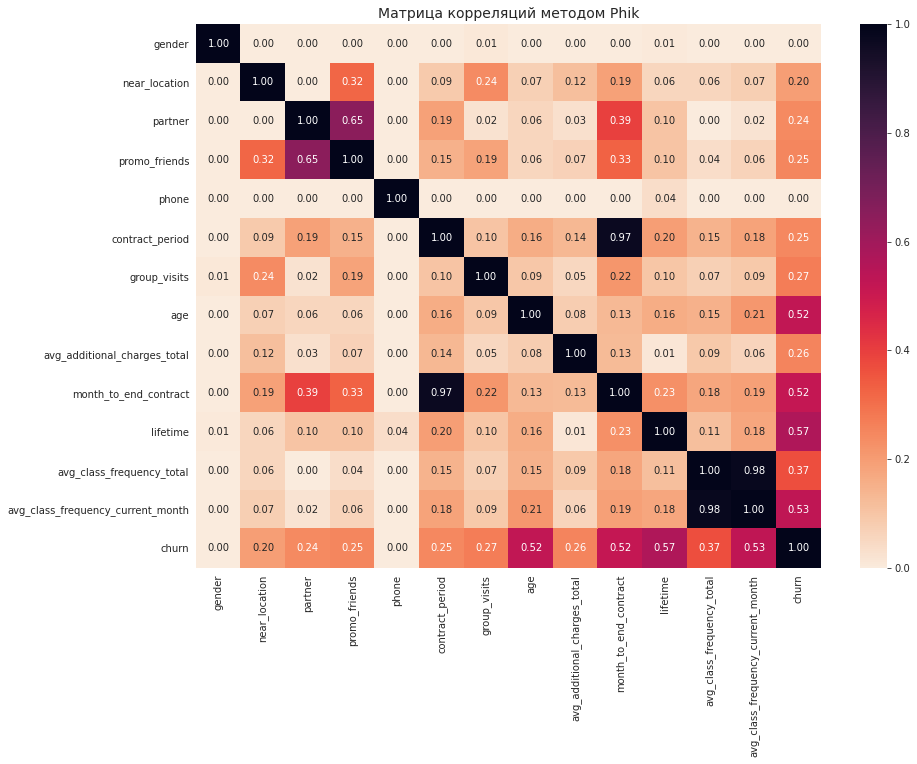

In [18]:
#вычисляем φk корреляций
phik_matrix = df.phik_matrix(interval_cols=['contract_period', 'age', 
                                            'avg_additional_charges_total', 
                                            'month_to_end_contract', 
                                            'lifetime', 'avg_class_frequency_total', 
                                            'avg_class_frequency_current_month'])

#создаём тепловую карту корреляций
plt.figure(figsize=(14, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap=sns.color_palette('rocket', as_cmap=True).reversed())
plt.title('Матрица корреляций методом Phik', fontsize=14)
plt.show()

- На построенной матрице корреляций мы наблюдаем сильную связь оттока с длительностью посещения фитнес-центра. Также весьма сильная связь со средней частотой посещения в неделю за последний месяц, возрастом клиентов и количеством месяцев до окончания абонемента.
- Полностью отсутствует связь с полом и наличием контактного телефона.
- Есть слабая связь с посещениями групповых занятий, общей суммой трат на дополнительные услуги центра, длительностью абонемента, участия в акции «Приведи друга», наличием корпоративной скидки и близким расположением фитнес-центра к работе или дому.
- Средняя частота посещений в неделю на протяжении всего абонемента имеет среднюю связь с оттоком.
    
Также мы можем заметить очень сильную связь между такими признаками:  
- Средняя частота посещений в неделю на протяжении всего абонемента и за последний месяц.
- Длительность абонемента и остаток по нему.
    
Сильная связь наблюдается между наличием скидки от компании-партнёра и скидки по акции «Приведи друга».

Остальные связи средние и слабые, особенно выделяется связь пола и наличия контактного телефона: у этих двух признаков связи нет вообще ни с какими другими.

## Построение модели прогнозирования оттока клиентов

Нам предстоит обучить несколько моделей двумя способами и сравнить качество прогнозов по каждой из них. Для этого мы проверим следующие характеристики:

- `Accuracy` — доля правильных ответов, предсказанных моделью. На этот параметр не будем сильно опираться, так как доля ушедших в отток в нашем датасете значительно ниже оставшихся, что может привести к смещению результатов.
- `Precision` — доля правильных положительных ответов среди всех ответов, предсказанных моделью как положительные. Этот показатель важен, когда важно минимизировать количество ложных срабатываний.
- `Recall` — доля реальных положительных объектов (ушедших клиентов), которые модель смогла правильно идентифицировать. Важен, когда необходимо максимально выявить все положительные случаи.
- `F1-score` — гармоническое среднее между precision и recall. Используется для оценки баланса между этими двумя метриками.
- `ROC AUC` — площадь под кривой ROC (Receiver Operating Characteristic). Этот показатель измеряет способность модели различать классы. Чем ближе значение ROC AUC к 1, тем лучше модель справляется с классификацией.

Метрики можно будет вывести единообразно, потому создадим функцию.

In [19]:
#создадим функцию для вывода всех метрик
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    print('---'*20)

In [20]:
#разделяем данные на признаки и целевую переменную
X = df.drop(columns=['churn'], axis = 1)
y = df['churn']
#разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Линейные алгоритмы машинного обучения лучше работают на стандартизированных данных, но проверим, как будет прогнозировать отток логистическая регрессия без стандартизации.

In [21]:
#строим модель логистической регрессии без стандартизации
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
#делаем прогноз
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

#строим модель случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
#делаем прогноз
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

А теперь стандартизируем данные, приведя их к стандартному нормальному распределению.

In [22]:
#стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#строим модель логистической регрессии
st_lr_model = LogisticRegression(random_state=0)
st_lr_model.fit(X_train_st, y_train)
#делаем прогноз
st_lr_predictions = st_lr_model.predict(X_test_st)
st_lr_probabilities = st_lr_model.predict_proba(X_test_st)[:, 1]

Для сравнения выведем попарно метрики всех обученных моделей.

In [23]:
#выведем метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities, 'Метрики для модели логистической регрессии без стандатризации:')
print_all_metrics(y_test, st_lr_predictions, st_lr_probabilities, 'Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии без стандатризации:
	Accuracy: 0.92
	Precision: 0.89
	Recall: 0.81
	F1: 0.85
	ROC_AUC: 0.97
------------------------------------------------------------
Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	F1: 0.87
	ROC_AUC: 0.98
------------------------------------------------------------
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97
------------------------------------------------------------


- Для моделей логистической регрессии разница есть в пользу стандартизированных данных. При этом по всем показателям эта модель показывает значения выше:
    - Доля правильных ответов: 94%.
    - Доля правильных положительных ответов: 90%.
    - Доля реально ушедших клиентов, которых смогла обнаружить модель: 85%.
    - Баланс между метриками precision и recall выше, чем в других проверенных моделях: 87% против 85%.
    - Кроме того, способность данной модели различать классы на 1% выше, чем у других.
- Модель случайного леса по всем метрикам немного хуже модели логистической регрессии, но по доле реальных положительных ответов на 2% опережает модель логистической регрессии до стандартизации данных, а по доле правильных ответов уступает 1% даже ей.
    
Важно учитывать, какая из двух метрик: precision или recall — более ценна для бизнеса. Если стоимость удержания через корпоративные скидки, промо и рекламные акции ниже стоимости потерянного клиента, который может тратить деньги и на доп. услуги в фитнес-центре, то нам интереснее метрика recall. Впрочем, получившиеся результаты показывают, что обе метрики выше в модели логистической регрессии после стандартизации имеющихся данных.

## Кластеризация клиентов

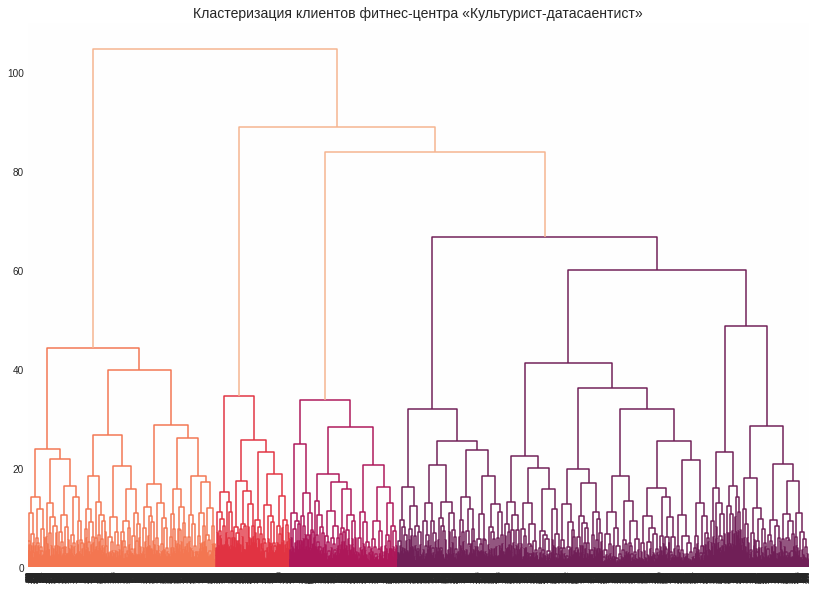

In [24]:
#стандартизируем данные без столбца с оттоком
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop(['churn'], axis=1))
#строим матрицу расстояний
linked = linkage(X_sc, method='ward')
#меняем тему для белого фона
plt.style.use('seaborn-darkgrid')
#создаём дендрограмму
plt.figure(figsize=(14, 10))
dendrogram(linked, orientation='top') 
plt.title('Кластеризация клиентов фитнес-центра «Культурист-датасаентист»', fontsize=14)
plt.show()

Нам предложено разбить клиентов на 5 кластеров, но, глядя на дендрограмму, можно было бы предположить, что более объективным было бы разделение клиентов на 6 групп на расстоянии от 50. 

Впрочем, небольшой эксперимент показывает, что при разбивке клиентов на 6 кластеров мы получаем 2 близкие по доле оттока группы с незначительными отличиями в распределении признаков.

In [25]:
#прогнозируем кластеры клиентов
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
#сохраняем метки в датасет
df['cluster_km'] = labels
#считаем средние значения по кластерам + размеры
df_cluster = df.groupby('cluster_km').mean()
df_cluster['count'] = df.groupby('cluster_km').age.count() #считаем размеры кластеров
round(df_cluster.sort_values('churn').T, 2)

cluster_km,0,4,1,2,3
gender,0.50,0.56,0.52,0.50,0.49
near_location,0.96,0.98,0.86,0.00,1.00
partner,0.78,0.36,0.47,0.46,0.35
promo_friends,0.57,0.23,0.31,0.08,0.24
phone,1.00,1.00,0.00,1.00,1.00
contract_period,10.89,2.67,4.79,2.35,1.95
group_visits,0.54,0.47,0.43,0.22,0.34
age,29.98,30.13,29.30,28.48,28.17
avg_additional_charges_total,160.76,161.66,143.96,135.46,131.62
month_to_end_contract,9.95,2.46,4.48,2.20,1.86


Как мы можем увидеть на этой сводной таблице, кластеры разделили клиентов неравномерно, но две самые большие по размерам группы показывают противоположные по доле оттока значения. 
- Кластер с индексом 0 собрал в себя данные о 1010 клиентах, вероятность оттока которых сведена к минимуму: 3%.
- Кластер с индексом 3 содержит данные 1262 клиентов, вероятность оттока которых 51% — из этой группы мы теряем больше половины клиентов. 

Рассмотрим особенности каждой группы с помощью графиков, чтобы найти самые характерные черты в каждой из них.

### Кластер с индексом 0: Гуру качалки

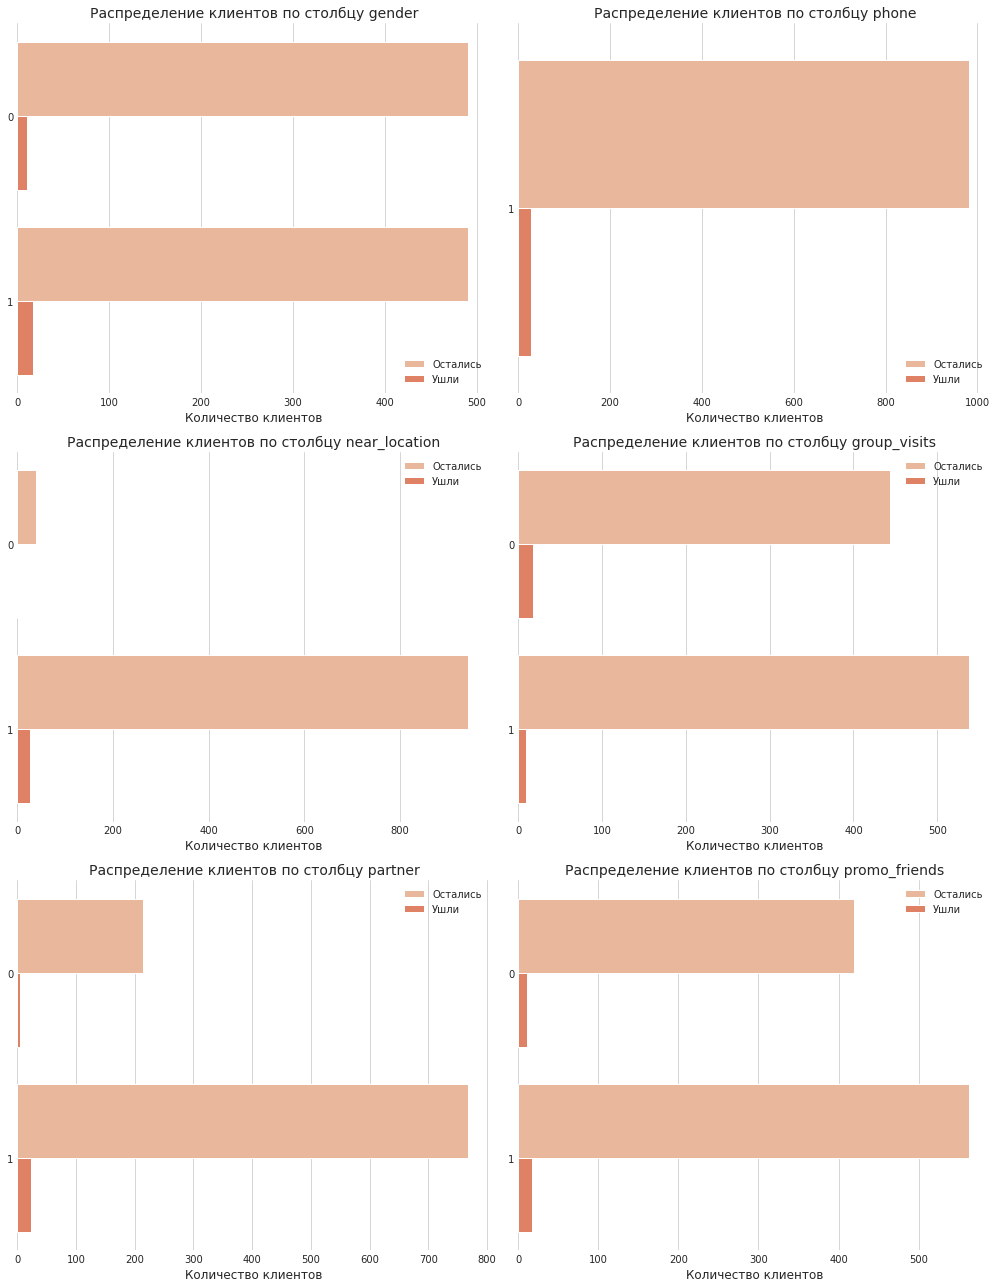

In [26]:
cluster_km = [0, 1, 2, 3, 4]
#возвращаем светлую тему
sns.set_style('whitegrid')
#создаем сетку для графиков
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
#перебираем категориальные признаки и вызываем функцию для построения графиков
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    df_countplot(feature, f'Распределение клиентов по столбцу {feature}', ax=axes[row, col], cluster_number=cluster_km[0])
plt.tight_layout()
plt.show()

- В этой группе равное распределение между мужчинами и женщинами.
- Все клиенты указали номер телефона.
- Большинство клиентов проживает или работает рядом с фитнес-центром.
- Больше половины из них посещают групповые занятия.
- Большая часть из клиентов является сотрудниками компаний-партнеров.
- Более половины клиентов привлечены по акции «Приведи друга».

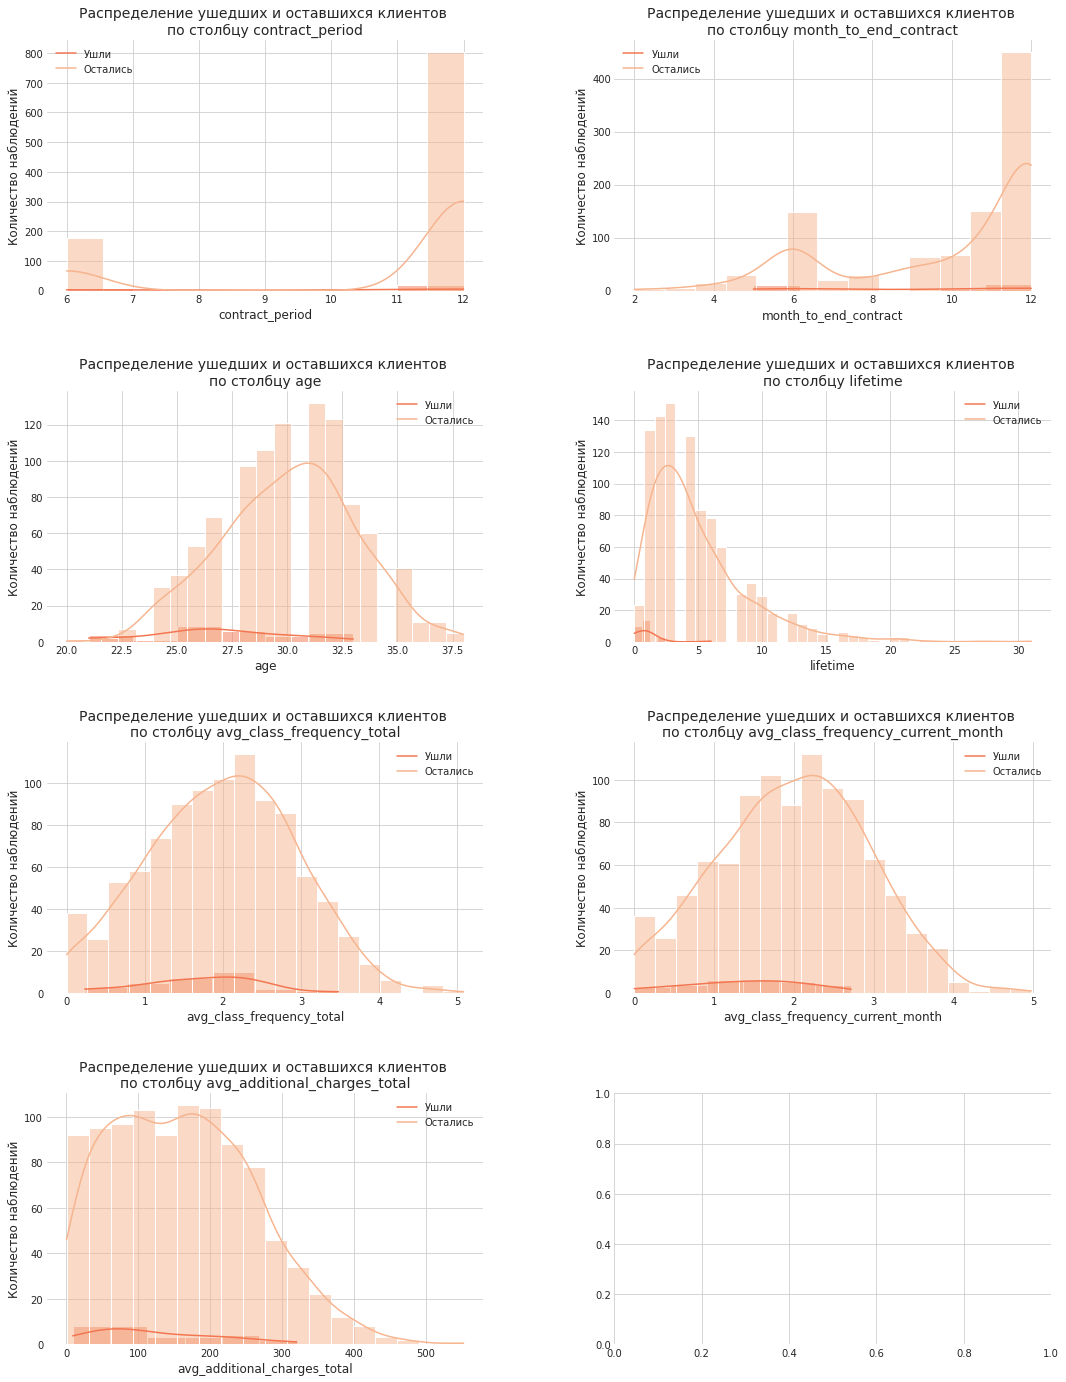

In [27]:
#создаем сетку для графиков
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
#перебираем количественные признаки и вызываем функцию для построения гистограммы распределения
for i, feature in enumerate(quantitative_features):
    row = i // 2
    col = i % 2
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 1, ax=axes[row, col], cluster_number=cluster_km[0])
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 0, ax=axes[row, col], cluster_number=cluster_km[0])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

- Почти все клиенты приобретают годовые абонементы.
- Остаток абонемента распределён неравномерно, но большинство клиентов недавно приобрели абонемент.
- Распределение по возрасту указывает на самый популярный возраст в 31 год.
- В этой группе оказались клиенты, которые посещают фитнес-центр дольше остальных, впрочем, большая часть клиентов начала посещать центр меньше полугода назад.
- Клиенты достаточно стабильно посещают занятия со средней частотой более двух раз в неделю, хотя за последний месяц показатели чуть хуже, чем за всё время действия абонемента.
- В большинстве своём клиенты этой группы потратили до 270 тысяч рублей, после этой суммы на графике распределения наблюдается спад.

На основании анализа кластера можем присвоить группе внутреннее название **Гуру качалки**.

### Кластер с индексом 1: Середнячки

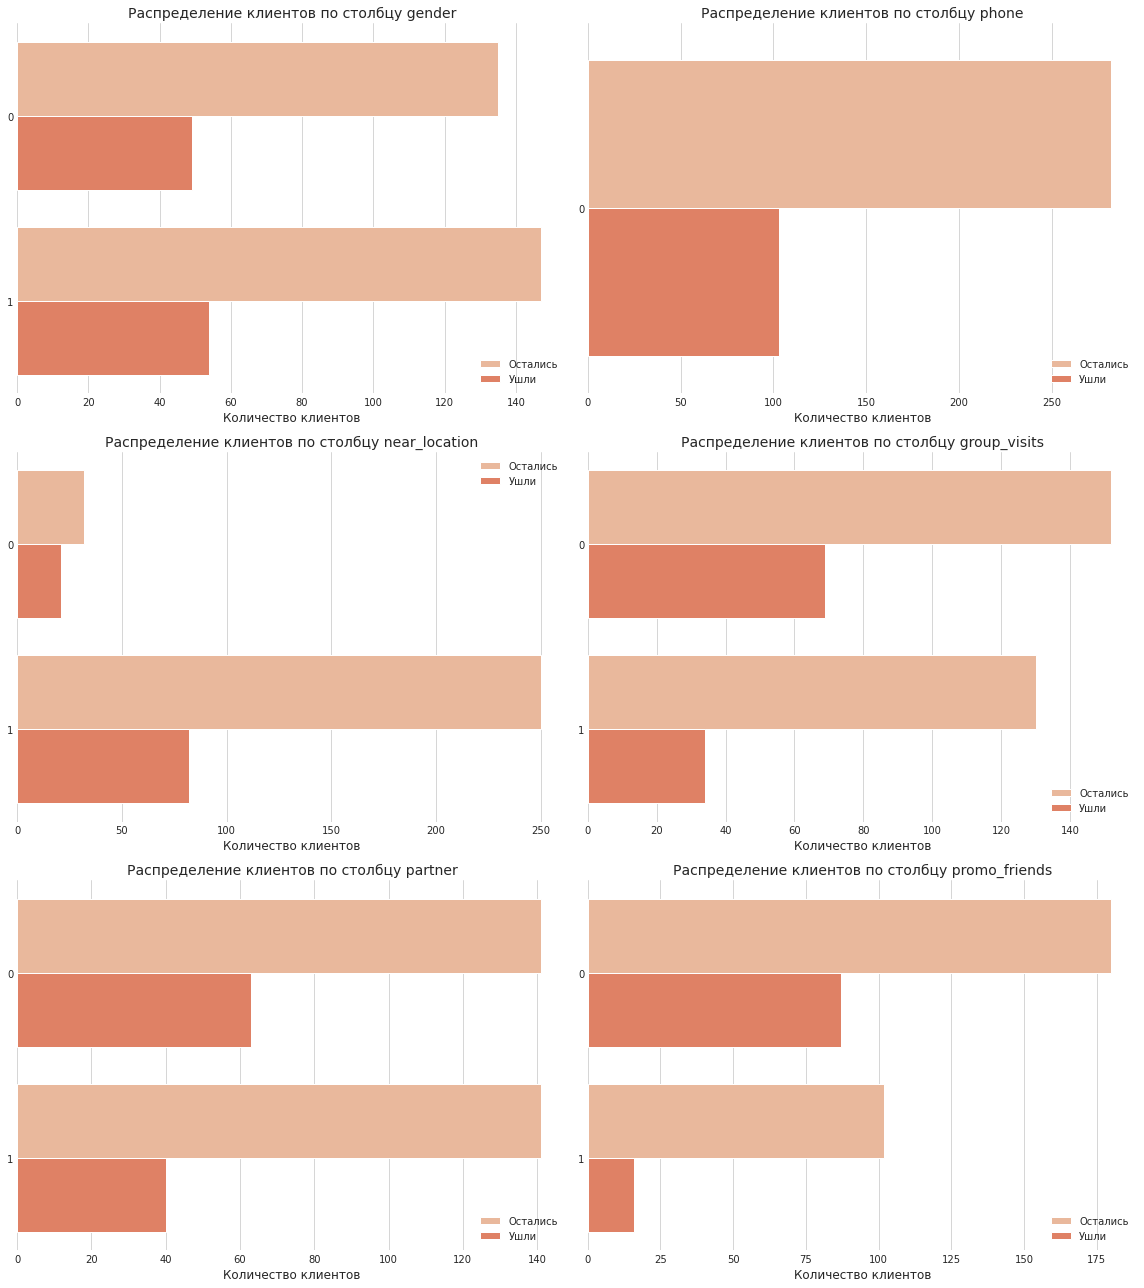

In [28]:
#создаем сетку для графиков
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
#перебираем категориальные признаки и вызываем функцию для построения графиков
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    df_countplot(feature, f'Распределение клиентов по столбцу {feature}', ax=axes[row, col], cluster_number=cluster_km[1])
plt.tight_layout()
plt.show()

- В данной группе есть небольшое преобладание клиентов с полом под числовым лейблом 1.
- Все клиенты не оставляли свой контактный номер телефона, что свидетельствует о неполных данных при анкетировании.
- Большая часть клиентов проживает или работает рядом с фитнес-центром.
- Больше половины клиентов не посещают групповые занятия, и половина из них уходит в отток.
- Среди остающихся равное количество клиентов между использующими и не использующими корпоративные программы, но без них уровень оттока выше.
- Большая часть клиентов посещает фитнес-центр без акции «Приведи друга», но треть клиентов без промо уходит в отток, когда у клиентов по акции доля оттока небольшая.

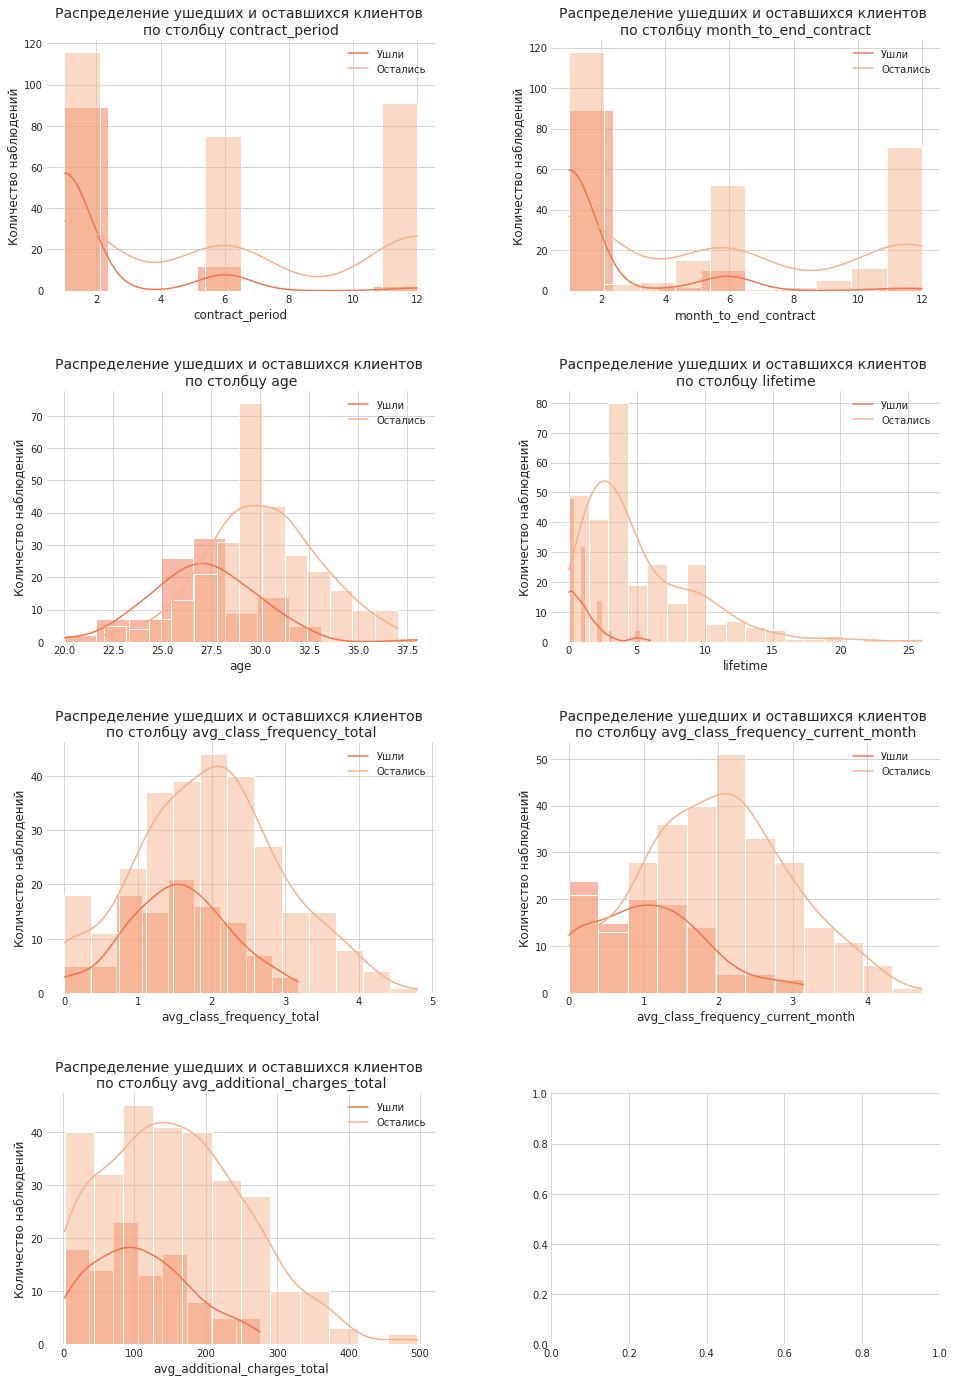

In [29]:
#создаем сетку для графиков
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
#перебираем количественные признаки и вызываем функцию для построения гистограммы распределения
for i, feature in enumerate(quantitative_features):
    row = i // 2
    col = i % 2
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 1, ax=axes[row, col], cluster_number=cluster_km[1])
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 0, ax=axes[row, col], cluster_number=cluster_km[1])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

- Большинство клиентов, которые перестали пользоваться услугами, покупали только краткосрочные абонементы. А те, кто остался, приобретают абонементы разных видов, и их довольно много.
- Остатки абонементов распределены равномерно и для ушедших, и для удержанных клиентов.
- Большинству оставшихся клиентов около 29 лет, а возраст ушедших распределён нормально с пиком на 27 годах.
- Большая часть удержанных клиентов посещает фитнес-центр до 4 месяцев, среди ушедших большинство ушло в отток в первые 2 месяца.
- Средняя посещаемость в неделю в этой группе около 2 раз в неделю за весь период абонемента и за последний месяц, а ушедшие в отток посещают центр около 1–1,5 раз в неделю.
- Среди удержанных клиентов траты распределены нормально с пиком на 150 тысячах, а у ушедших пик приходится на 100 тысяч рублей.

Эту группу клиентов можно смело назвать **Середнячки**.

### Кластер с индексом 2: Залётные

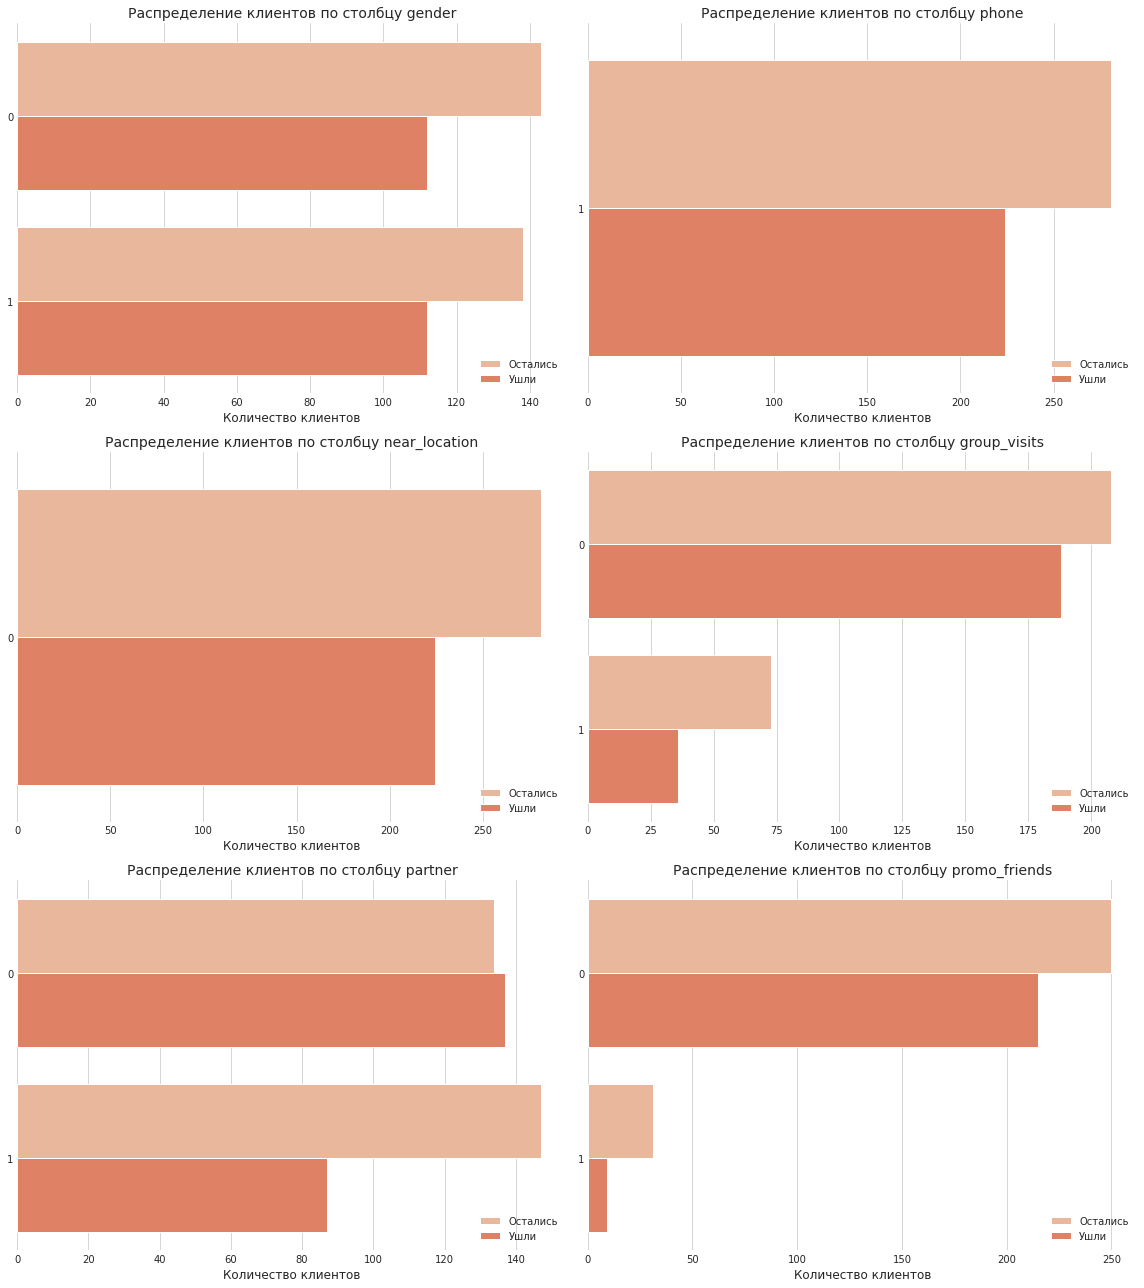

In [30]:
#создаем сетку для графиков
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
#перебираем категориальные признаки и вызываем функцию для построения графиков
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    df_countplot(feature, f'Распределение клиентов по столбцу {feature}', ax=axes[row, col], cluster_number=cluster_km[2])
plt.tight_layout()
plt.show()

- В этой группе преобладают клиенты с полом под числовым лейблом 0, доля ушедших среди них незначительно ниже.
- В этой группе есть номера телефонов всех клиентов.
- Никто из клиентов не живет или не работает рядом с фитнес-центром.
- Большая часть клиентов не посещает групповые занятия, и почти половина из них уходит в отток.
- Большая часть клиентов этой группы пользуется корпоративными скидками, но если их нет, то уровень оттока выше удержания.
- Почти никто из клиентов этой группы не участвует в акции «Приведи друга», почти половина из них уходит в отток.

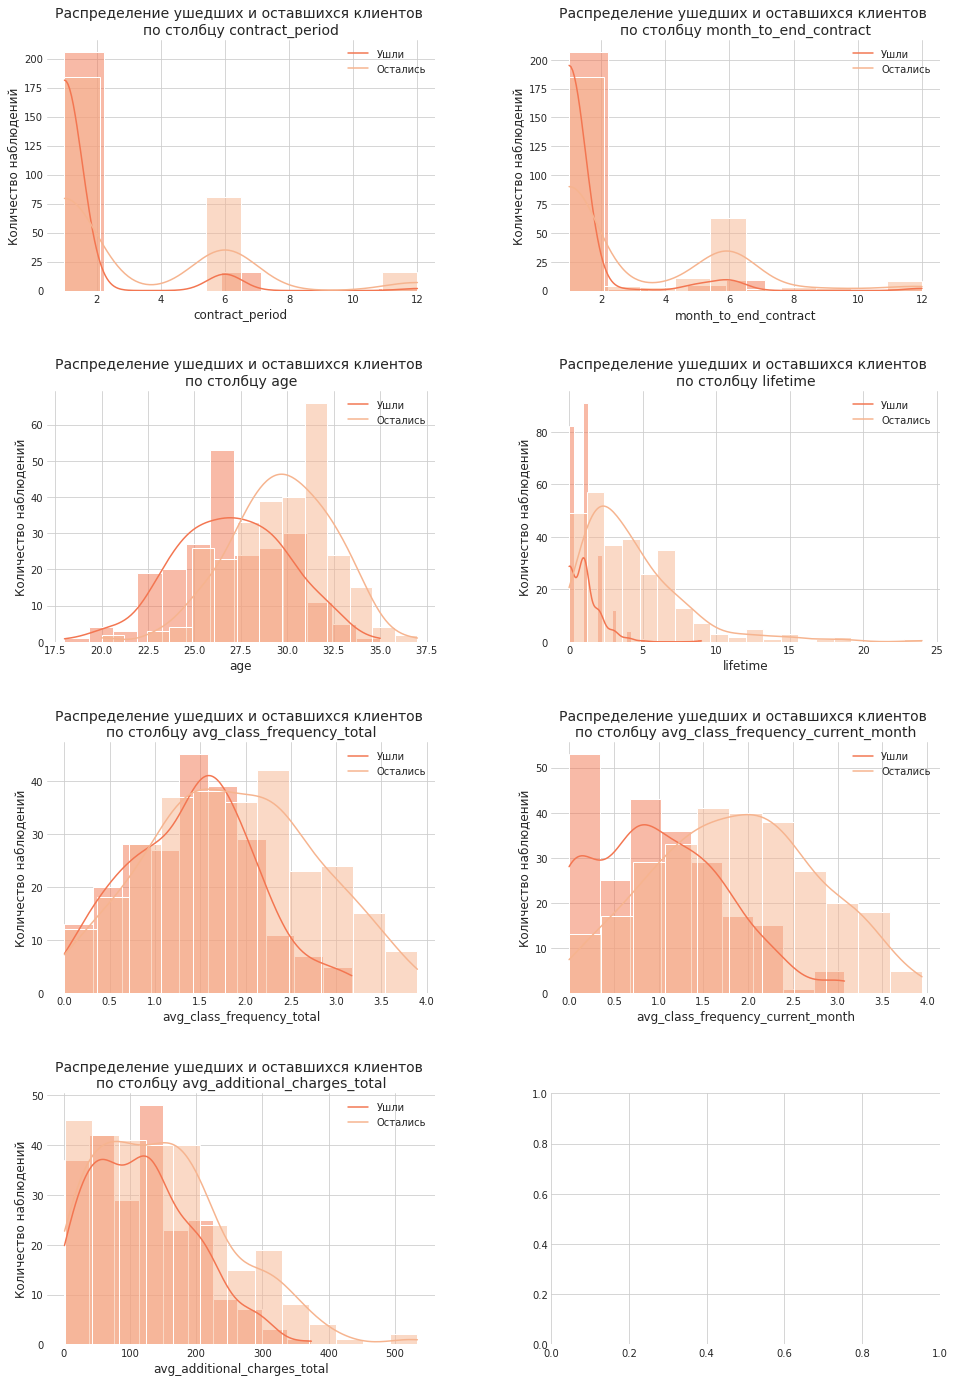

In [31]:
#создаем сетку для графиков
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
#перебираем количественные признаки и вызываем функцию для построения гистограммы распределения
for i, feature in enumerate(quantitative_features):
    row = i // 2
    col = i % 2
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 1, ax=axes[row, col], cluster_number=cluster_km[2])
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 0, ax=axes[row, col], cluster_number=cluster_km[2])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

- В группе преобладают короткие абонементы, соответственно, остаток тоже в большинстве своём около месяца.
- Среди ушедших мы наблюдаем нормальное распределение по возрасту с пиком на 26 годах, среди остающихся распределение нормальным уже назвать нельзя, а большая часть клиентов в возрасте 32 лет.
- Преобладающее количество ушедших клиентов посещает фитнес-центр 1–2 месяца, а среди оставшихся длительность посещения распределена до 8 месяцев.
- За весь срок абонемента средняя частота посещений у ушедших в отток около 1,5 раз в неделю, что очень близко к показателям оставшихся клиентов.
- За последний месяц средняя частота посещений среди ушедших снизилась: они либо вообще перестали ходить, либо ходят около раза в неделю. А у остающихся распределение нормальное с пиком на 2 посещениях в неделю — показатели стали выше.
- Траты у ушедших нормально не распределены, есть два пика на 50 и 140 тысячах. Оставшиеся клиенты платят на доп. услуги чуть больше.

Для внутренного пользования можно присвоить этой группе наименование **Залётные**.

### Кластер с индексом 3: Подснежники

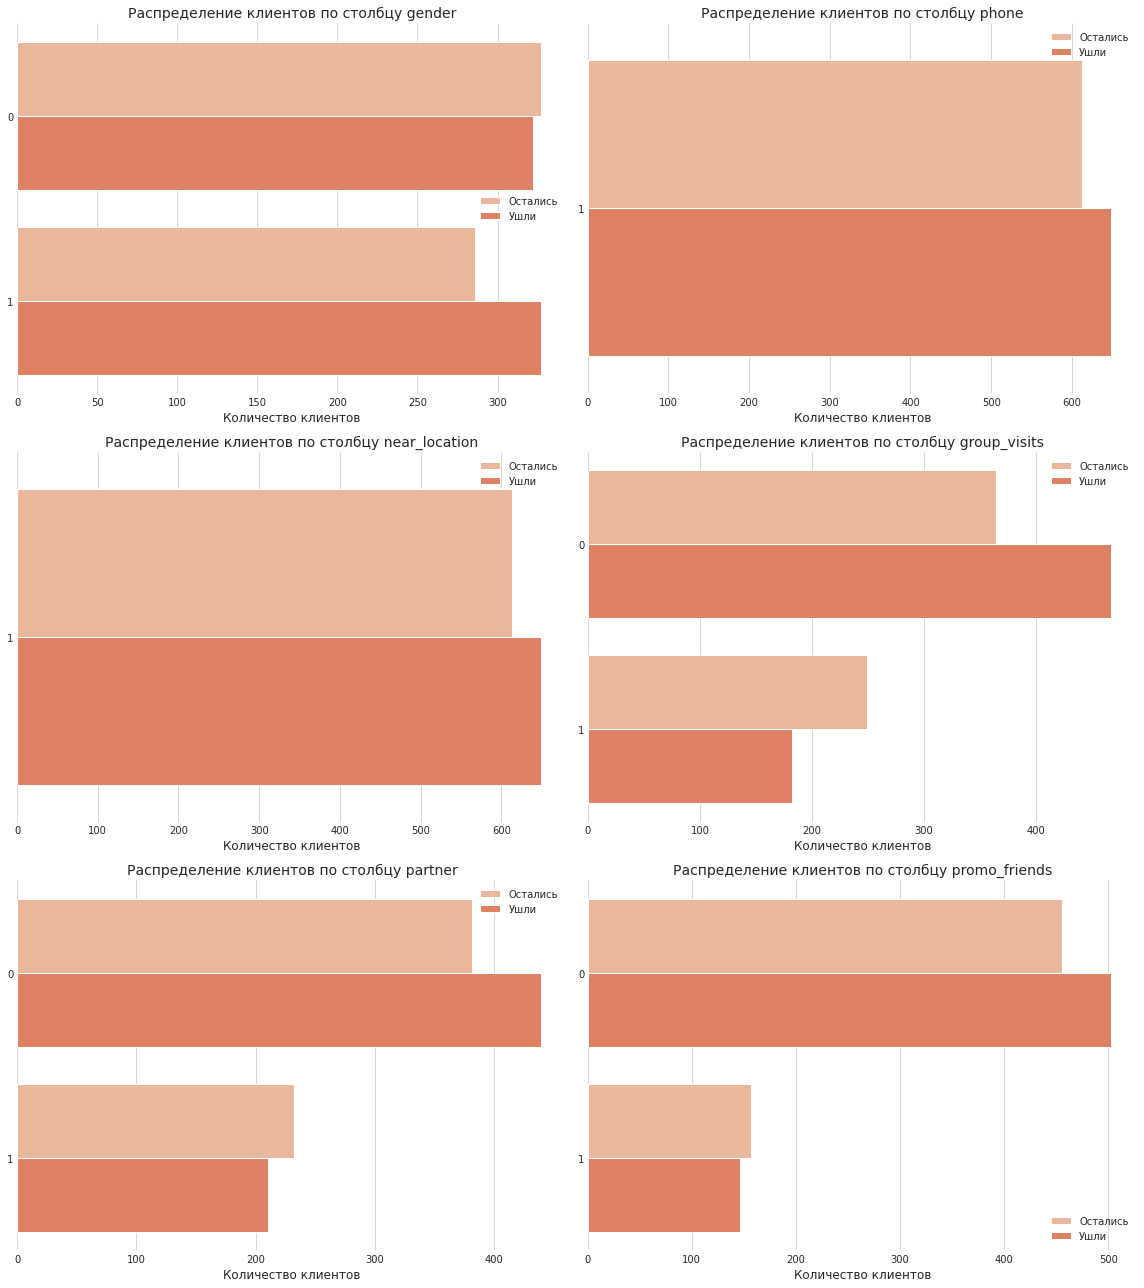

In [32]:
 #создаем сетку для графиков
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
#перебираем категориальные признаки и вызываем функцию для построения графиков
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    df_countplot(feature, f'Распределение клиентов по столбцу {feature}', ax=axes[row, col], cluster_number=cluster_km[3])
plt.tight_layout()
plt.show()

- Наибольший отток у клиентов с полом под числовым лейблом 1. Но в обоих случаях отток очень большой.
- Все клиенты оставили свои номера телефонов при анкетировании.
- Все клиенты проживают или работают рядом с фитнес-центром.
- Большая часть не посещает групповые визиты. Чуть ниже доля оттока у посещающих.
- Большинство клиентов этой группы не пользуются корпоративными программами, но у тех, кто её использует, отток ниже уровня удержания.
- Доля клиентов, привлеченных с помощью акции «Приведи друга», низкая, но среди них уровень оттока меньше удержания.

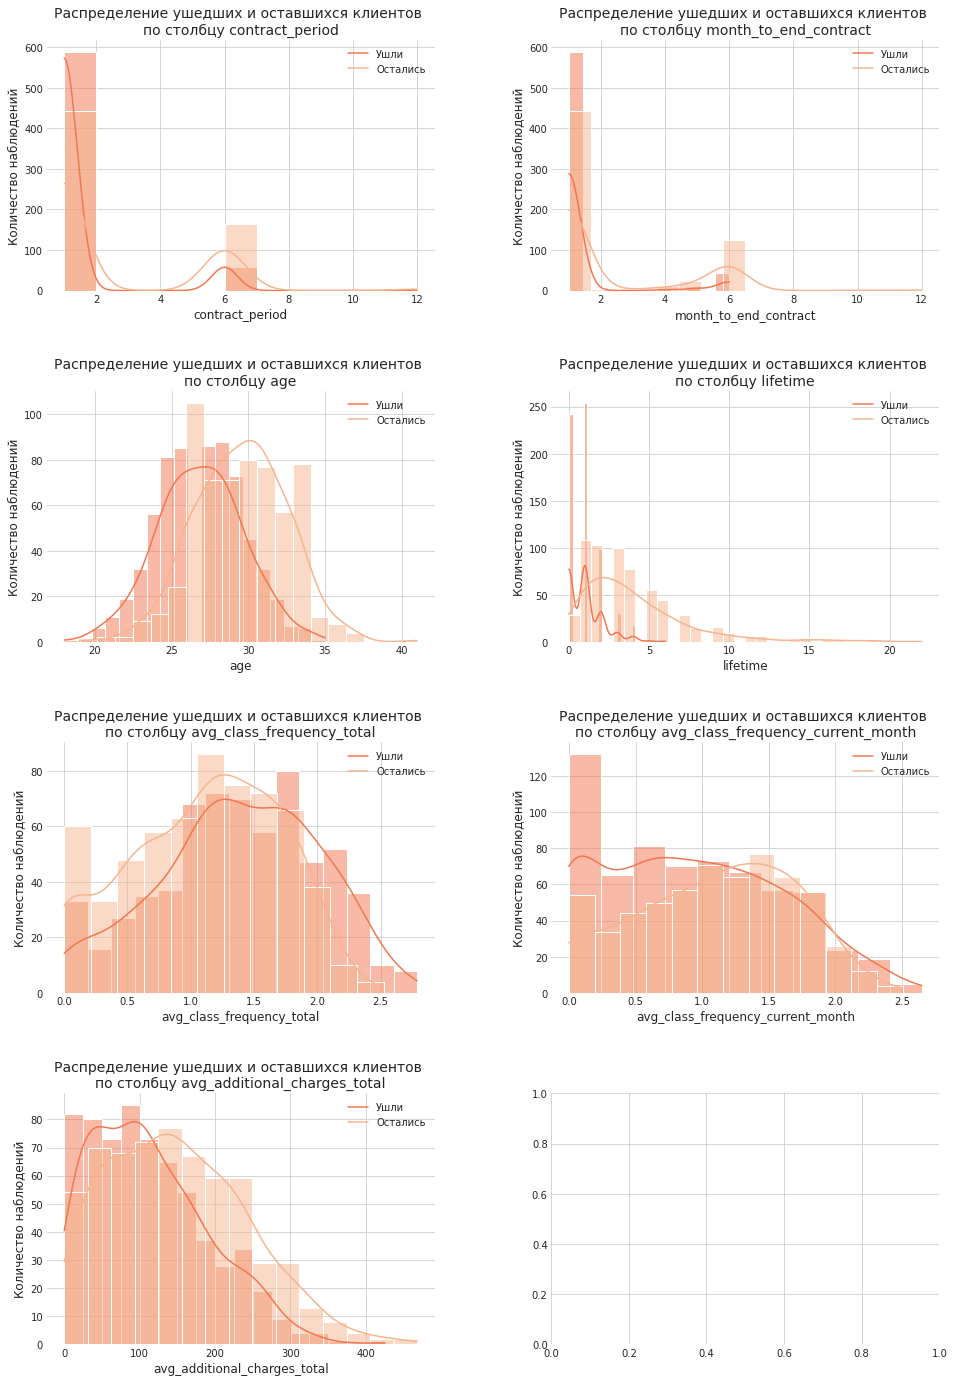

In [33]:
#создаем сетку для графиков
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
#перебираем количественные признаки и вызываем функцию для построения гистограммы распределения
for i, feature in enumerate(quantitative_features):
    row = i // 2
    col = i % 2
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 1, ax=axes[row, col], cluster_number=cluster_km[3])
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 0, ax=axes[row, col], cluster_number=cluster_km[3])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

- В этой группе преобладают короткие абонементы, малый остаток по этой же причине.
- Среди ушедших есть разрыв в возрасте 26 лет, но много клиентов до и после 26 ушли в отток. Среди оставшихся преобладают 26-летние, но пик распределения указывает на 30-летний возраст удержанных клиентов.
- Наибольшая доля ушедших посещает фитнес-центр до 2 месяцев, а оставшиеся распределены нормально с пиком на 3 месяцах.
- В целом средняя частота посещений не превышает 3 раз в неделю, пик для ушедших приходится на 1,2 и 1,7 раз в неделю за время действия абонемента, а за последний месяц около 0 и 0,6 раз в неделю. Оставшиеся тоже ходят редко: за последний месяц около 1,5 раз в неделю, а за весь абонемент пик распределения приходится на 1,2 раза в неделю посещений.
- Траты сразу ушедших в отток распределены с пиками около 50 и 100 тысяч, а у удержанных — около 150 тысяч рублей.

Хоть у нас и нет статистики по датам начала посещений, можно смело назвать эту группу **Подснежники**.

### Кластер с индексом 4: Районные

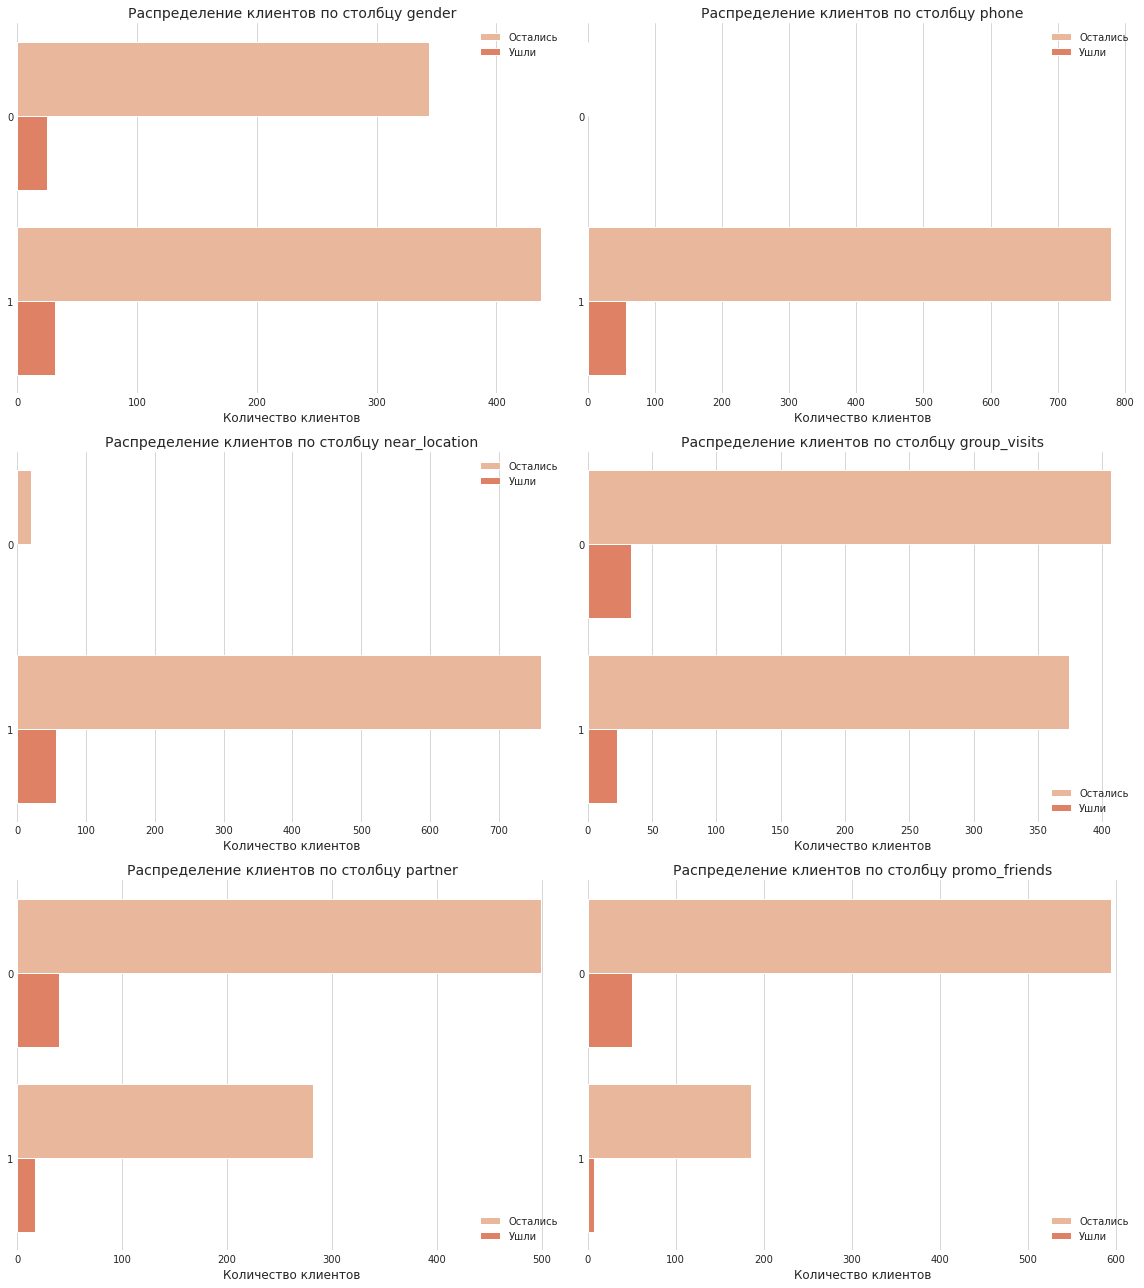

In [34]:
#создаем сетку для графиков
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
#перебираем категориальные признаки и вызываем функцию для построения графиков
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    df_countplot(feature, f'Распределение клиентов по столбцу {feature}', ax=axes[row, col], cluster_number=cluster_km[4])
plt.tight_layout()
plt.show()

- В последней рассматриваемой группе преобладают клиенты с полом под числовым лейблом 1, с уровнем оттока меньше, чем у пола с числовым лейблом 0.
- Номера телефонов есть почти ото всех клиентов группы.
- Большинство проживает или работает рядом с фитнес-центром, а те, кто нет, продолжают посещать фитнес-центр, несмотря на трудности логистики.
- Выше доля клиентов, которые не посещают групповые занятия.
- Низкая доля клиентов из компаний-партнеров.
- Большая часть клиентов посещает фитнес-центр не по акции «Приведи друга».

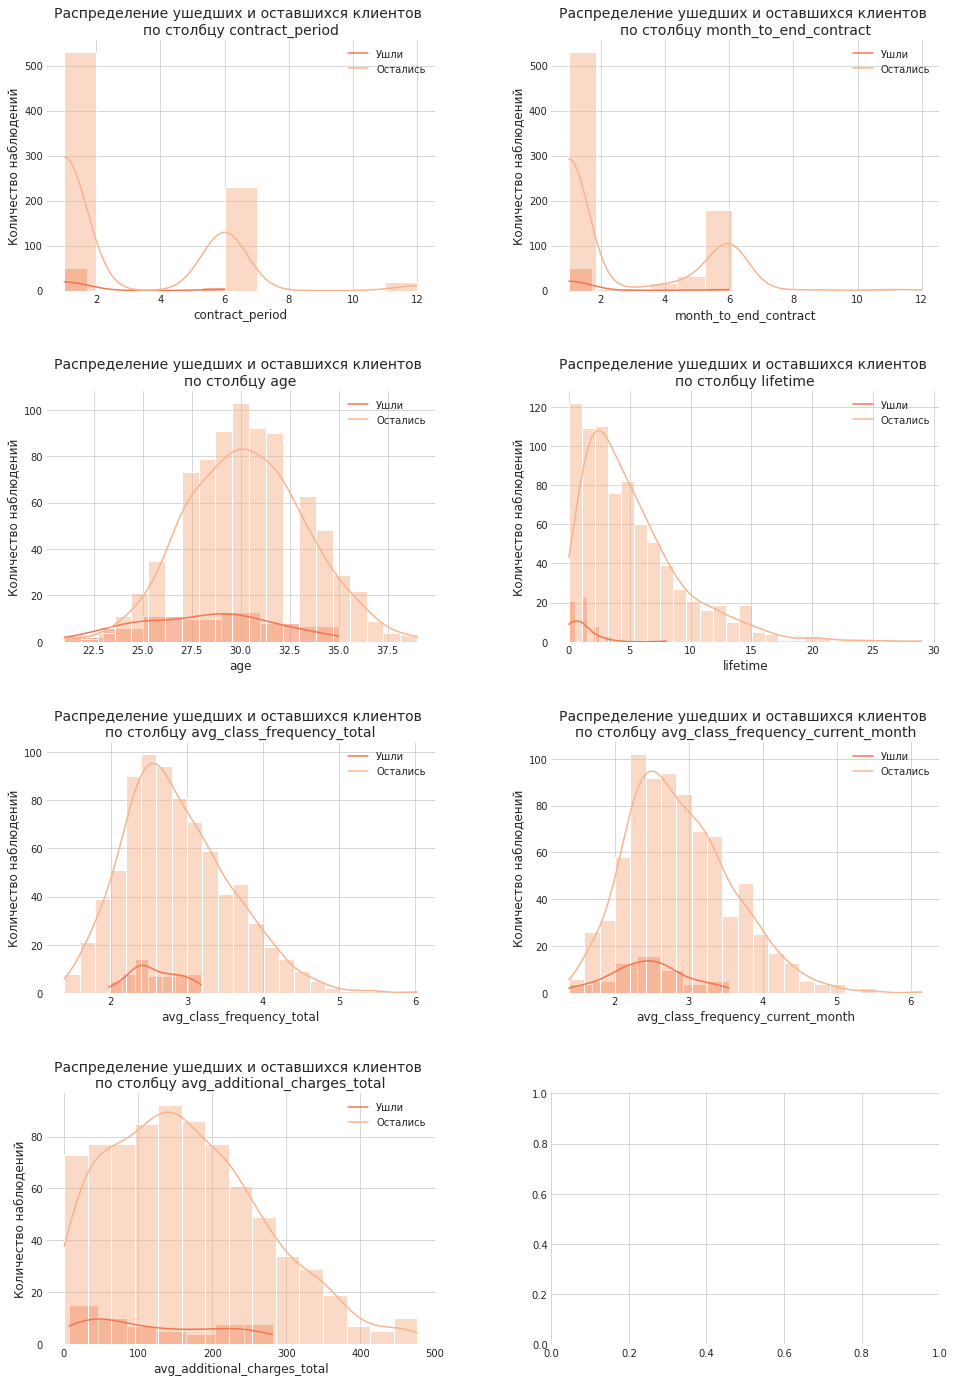

In [35]:
#создаем сетку для графиков
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
#перебираем количественные признаки и вызываем функцию для построения гистограммы распределения
for i, feature in enumerate(quantitative_features):
    row = i // 2
    col = i % 2
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 1, ax=axes[row, col], cluster_number=cluster_km[4])
    df_histplot(feature, f'Распределение ушедших и оставшихся клиентов \nпо столбцу {feature}', 
                feature, 0, ax=axes[row, col], cluster_number=cluster_km[4])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

- Большинство клиентов приобретают короткие абонементы, но немало и тех, кто выбирает полугодовые.
- Остаток полугодовых распределён нормально, а у тех, кто приобретал годовые абонементы, остаток колеблется от полугода и меньше.
- Так как в этой группе небольшой уровень оттока, то мы можем только отметить возраст оставшихся: это клиенты от 27 до 32 с пиком на 30 годах. Возраст ушедших равномерно «размазан» от самого молодого возраста и до 35.
- В этой группе преобладают клиенты, пришедшие до 5 месяцев, с пиком распределения на уровне 2–3 месяцев.
- Клиенты этой группы посещают фитнес-центр достаточно часто и стабильно, пик распределения приходится на 2,5 раза в неделю и за период абонемента, и за последний месяц.
- Эта группа тратит чаще и больше: пик распределения около 150 тысяч, но немало трат до 500.

Этот кластер для внутреннего пользования можно обозначить как **Районные**.

## Выводы и рекомендации

В рамках этого проекта мы изучили данные о 4000 клиентах фитнес-центра «Культурист-датасаентист». Мы рассмотрели эти данные в таблицах и на графиках и на их основе создали модель машинного обучения. Эта модель позволяет с точностью до 85% прогнозировать, какие клиенты могут уйти.

Кроме того, мы разделили клиентов на группы и выделили пять наиболее распространённых типов пользователей. Вот они:

**Гуру качалки**:

В основном активные и лояльные клиенты, проживающие или работающие рядом с фитнес-центром, с длительными абонементами и высокой частотой посещений. Большая часть из них – сотрудники компаний-партнеров и привлечены по акции «приведи друга». Они активно пользуются дополнительными услугами фитнес-центра и имеют низкий уровень оттока: 3%.

**Районные**:

В основном проживают или работают рядом с фитнес-центром, имеют среднюю длительность абонементов и высокую частоту посещений. Они активно пользуются дополнительными услугами фитнес-центра и имеют умеренный уровень оттока: 7%.

**Середнячки**:

В основном живут или работают рядом с фитнес-центром, имеют среднюю длительность абонементов и умеренную частоту посещений. Они не предоставили контактный телефон. Уровень оттока среди них умеренный: 27%.

**Залётные**:

Не проживают и не работают рядом с фитнес-центром, имеют короткие абонементы и низкую частоту посещений. Они не склонны посещать групповые занятия и реже пользуются дополнительными услугами. Уровень оттока среди них высокий: 44%.

**Подснежники**:

Все проживают или работают рядом с фитнес-центром, имеют короткие абонементы и низкую частоту посещений. Они не склонны посещать групповые занятия и редко пользуются дополнительными услугами. Уровень оттока среди них самый высокий: 51%.

---

Необходимо уделить особое внимание клиентам из групп «Середнячки», «Залётные» и «Подснежники». Для клиентов из группы «Залётные» основным препятствием может стать расстояние, а вот клиенты из группы «Подснежники» проживают рядом, поэтому есть больше возможностей для взаимодействия с ними.

Группа «Середнячки» намекает, что стоит искать способы для получения контактного номера телефона с клиентами, чтобы связаться с ними в случае прогнозируемого оттока. Например, можно отправлять им напоминания о посещениях и запланированных занятиях через SMS или push-уведомления в приложении.

Из доступных способов увеличения доли оставшихся клиентов можно предложить следующие:
- Расширить партнёрскую программу, чтобы увеличить долю клиентов, которые пользуются корпоративными скидками.
- Акции «приведи друга» также демонстрируют хорошие результаты, поэтому, возможно, стоит провести рекламную кампанию для увеличения доли клиентов, которые пользуются такими скидками. Кроме того, можно проанализировать перспективы реферальной программы.
- Групповые занятия также могут помочь уменьшить показатели оттока. Для этого можно провести информационную кампанию как в самом фитнес-центре, так и за его пределами.